> ### Note on Labs and Assignments:
>
> 🔧 Look for the **wrench emoji** 🔧 — it highlights where you're expected to take action!
>
> These sections are graded and are not optional.
>

# IS 4487 Lab 10: Classification Trees with SF Rent Data

## Outline

- Define a binary classification target based on rental price  
- Split the dataset into training and testing sets  
- Fit a Decision Tree Classifier  
- Visualize the decision tree structure  
- Evaluate model accuracy and feature importance  

In this lab, we’ll build a classification model to predict whether a rental listing in San Francisco is considered **"affordable"** based on its features.

We are continuing with the **SF Rent dataset** used in **Lab 9**, and will explore how classification trees can uncover patterns in rental prices.

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Labs/lab_10_classification.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



## Dataset Overview

**Dataset:** `rent.csv`  
Source: [TidyTuesday-2022-7-05](https://github.com/rfordatascience/tidytuesday/blob/main/data/2022/2022-07-05/rent.csv)

| Variable       | Type       | Description |
|----------------|------------|-------------|
| `post_id`      | Categorical| Unique listing ID |
| `date`         | Numeric    | Listing date (numeric format) |
| `year`         | Integer    | Year of listing |
| `nhood`        | Categorical| Neighborhood |
| `city`         | Categorical| City |
| `county`       | Categorical| County |
| `price`        | Numeric    | Listing price (USD) |
| `beds`         | Numeric    | Number of bedrooms |
| `baths`        | Numeric    | Number of bathrooms |
| `sqft`         | Numeric    | Square footage |
| `room_in_apt`  | Binary     | 1 = room in apartment |
| `address`      | Categorical| Street address |
| `lat`          | Numeric    | Latitude |
| `lon`          | Numeric    | Longitude |
| `title`        | Text       | Listing title |
| `descr`        | Text       | Listing description |
| `details`      | Text       | Additional details |

## Part 1: Clean and Prepare the Data

We'll repeat the cleaning process from Lab 9, including:
- Removing duplicates
- Dropping missing values in key columns
- Filtering out extreme outliers
- Converting data types

### Why This Matters:
Good models depend on clean, reliable inputs.


In [1]:
import pandas as pd

# Load dataset
url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2022/2022-07-05/rent.csv'
df = pd.read_csv(url)

# Drop duplicate listings using post_id
df = df.drop_duplicates(subset='post_id')

# Drop rows missing essential features
required_cols = ['price', 'beds', 'baths', 'sqft', 'lat', 'lon']
df = df.dropna(subset=required_cols)

# Remove outliers
df = df[df['price'].between(500, 20000)]
df = df[df['beds'].between(0, 10)]
df = df[df['baths'].between(0.5, 10)]
df = df[df['sqft'].between(100, 5000)]

# Convert columns to appropriate data types
df['beds'] = df['beds'].astype(int)
df['baths'] = df['baths'].astype(float)
df['sqft'] = df['sqft'].astype(int)
df['price'] = df['price'].astype(int)

# Reset index
df = df.reset_index(drop=True)

# Quick check
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984 entries, 0 to 1983
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   post_id      1984 non-null   object 
 1   date         1984 non-null   int64  
 2   year         1984 non-null   int64  
 3   nhood        1984 non-null   object 
 4   city         1984 non-null   object 
 5   county       1979 non-null   object 
 6   price        1984 non-null   int64  
 7   beds         1984 non-null   int64  
 8   baths        1984 non-null   float64
 9   sqft         1984 non-null   int64  
 10  room_in_apt  1984 non-null   int64  
 11  address      1768 non-null   object 
 12  lat          1984 non-null   float64
 13  lon          1984 non-null   float64
 14  title        1855 non-null   object 
 15  descr        1847 non-null   object 
 16  details      1874 non-null   object 
dtypes: float64(3), int64(6), object(8)
memory usage: 263.6+ KB


,post_id,date,year,nhood,city,county,price,beds,baths,sqft,room_in_apt,address,lat,lon,title,descr,details
0,4817227421,20141223,2014,alameda,alameda,alameda,1939,2,1.0,864,0,NaN,37.770600,-122.264800,"LIVE MORE, DRIVE LESS! JUST ACROSS THE BAY FRO...","Summer House Apartments 1826 Poggi St, Alameda...","2BR / 1Ba 864ft2 apartment date=""2014-12-23"" ..."
1,4710888130,20141012,2014,alameda,alameda,alameda,2250,2,1.0,1080,0,659,37.772835,-122.248585,2br Victortian Duplex Garden Apt.,"This 1903 ""Workingman's Victorian"" on a quiet ...","2BR / 1Ba 1080ft2 apartment date=""2014-11-02""..."
2,5961989126,20170126,2017,alameda,alameda,alameda,3995,3,2.0,1787,0,NaN,37.759231,-122.247190,3 BR/2 BA Queene Anne on Park St.,This charming 1787 sq ft meticulously maintain...,"3BR / 2Ba1787ft2 data-date=""2017-02-01"" data-t..."
3,4935175730,20150316,2015,alameda,alameda,alameda,2536,2,2.0,1225,0,NaN,37.753609,-122.249081,Spacious 2BR/2BA in a Great Community!,Tower Apartments CALL US: show contact infox3...,"2BR / 2Ba 1225ft2 apartment date=""2015-04-19""..."
4,4988581576,20150421,2015,alameda,alameda,alameda,2650,2,1.0,950,0,497,37.758922,-122.263314,"Upgraded 2B w/ Pool View, Short Walk to School...",Enjoy and experience the relaxing atmosphere o...,"2BR / 1Ba 950ft2 apartment date=""2015-04-20"" ..."


## Part 2: Create a Binary Target Variable

We'll classify whether a listing is **Affordable** (price < 3,000).

- 1 = Affordable
- 0 = Not Affordable

### Why This Matters:
To use classification trees, we need a target variable with a limited number of classes.


In [2]:
# Create binary target variable
df['affordable'] = (df['price'] < 3000).astype(int)

# Check target class distribution
df['affordable'].value_counts(normalize=True)


,proportion
affordable,
1,0.611391
0,0.388609


### 🔧 Try It Yourself – Part 2

1. Adjust the affordable threshold to $5,000 and check the class balance again  
2. Calculate what percentage of listings are labeled as affordable



Class balance with $5000 threshold:
affordable
1    0.917339
0    0.082661
Name: proportion, dtype: float64


Percentage of listings labeled as affordable: 91.73%


Reset the threshold to $3000

In [5]:
# Reset binary target back to 3000
df['affordable'] = (df['price'] < 3000).astype(int)

## Part 3: Select Features and Split Data

We'll use property characteristics as predictors:
- `beds`, `baths`, `sqft`

Then split the data into 80% training and 20% testing.

### Why This Matters:
Train/test splitting ensures our model is evaluated on unseen data.

In [6]:
from sklearn.model_selection import train_test_split

# Select features and target
X = df[['beds', 'baths', 'sqft']]
y = df['affordable']

# Create train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Check dimensions
X_train.shape, X_test.shape


((1587, 3), (397, 3))

### 🔧 Try It Yourself – Part 3

1. Add `lat` or `price_segment` as an additional feature in the x variable
2. Now add `price` as a feature/predictor.  What changes have occurred?

((1587, 5), (397, 5))

Instead of having three columns, or input features, we now have 5 input features. The two new input features are price_segment and price. Hopefully, the model will be more accurate with these two new input features I have introduced.

## Part 4: Build and Fit the Decision Tree Classifier

We'll train a `DecisionTreeClassifier` on our data.

### Why This Matters:
Decision trees make predictions by splitting data into branches using rules that reduce impurity.


In [9]:
from sklearn.tree import DecisionTreeClassifier

# Initialize classifier
clf = DecisionTreeClassifier(random_state=42)

# Train model on training data
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

### 🔧 Try It Yourself – Part 4

1. Create a second model called `clf_limited` with `max_depth=3`  
2. Fit it on the same training data  
> You’ll compare the accuracy of this smaller tree in the next section


DecisionTreeClassifier(max_depth=3, random_state=42)

## 5. Evaluate the Model

We’ll check how well the tree performed on the test data using:
- Accuracy score
- Confusion matrix

### Why This Matters:
We want to know how often the model is right and what kind of mistakes it makes.


In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Predict on test set
y_pred = clf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Test Accuracy: 1.0
Confusion Matrix:
 [[146   0]
 [  0 251]]


### 🔧 Try It Yourself – Part 5

1. Use the `clf_limited` model you created in Part 4 to predict on the test set  
2. Calculate and print the **test accuracy** for `clf_limited`  
3. Compare the test accuracy of `clf_limited` to the original `clf`. Which performs better?


Test Accuracy (clf_limited): 1.0


Both clf and clf_limited have accuracy scores of 1.0, which seems pretty suspicious. This makes me question the integrity of the second model. According to this metric alone, both of these models are equally accurate.

## Part 6: Visualize Tree and Feature Importance

We’ll plot the tree and rank the most important predictors.

### Why This Matters:
Tree plots explain the model's logic. Feature importance shows what drives predictions.


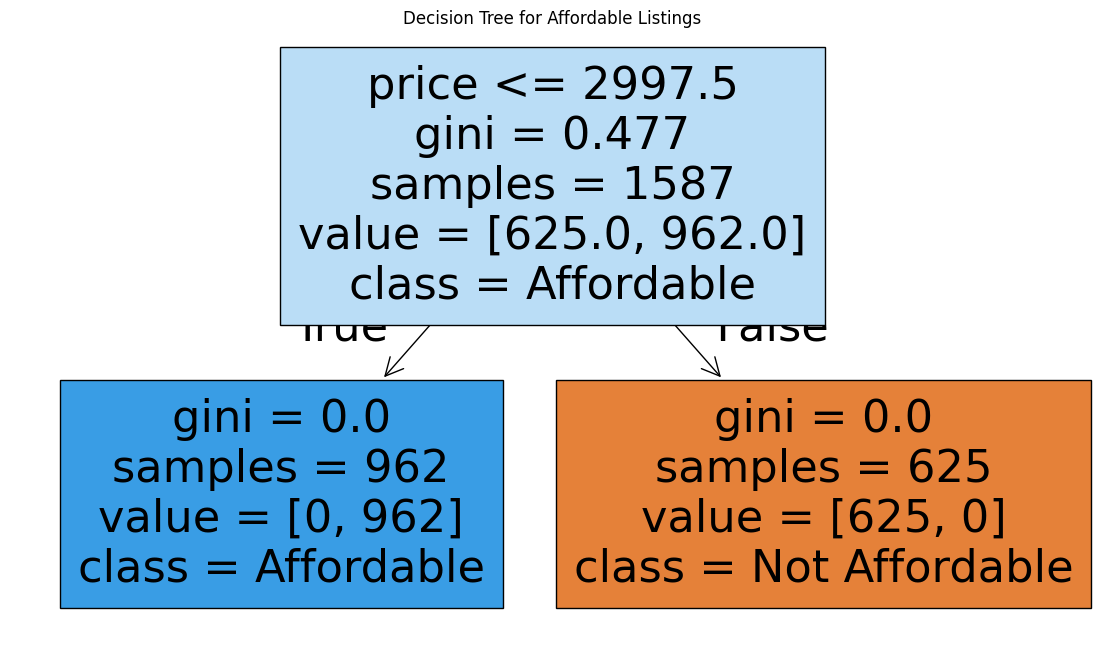

In [15]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Plot decision tree
plt.figure(figsize=(14, 8))
plot_tree(clf, feature_names=X.columns, class_names=['Not Affordable', 'Affordable'], filled=True)
plt.title("Decision Tree for Affordable Listings")
plt.show()


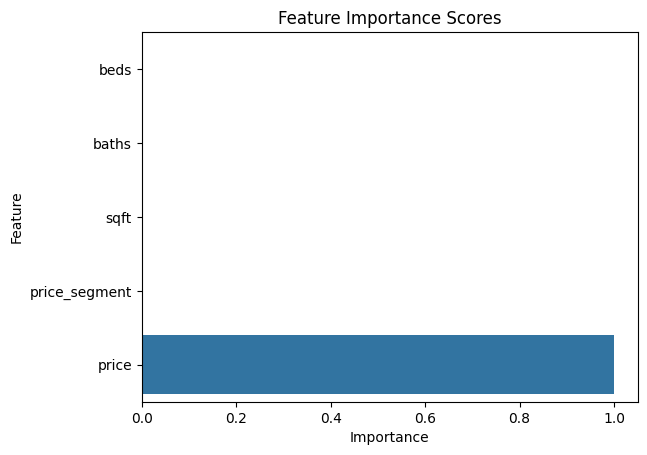

In [16]:
import seaborn as sns

# Plot feature importance
feat_imp = pd.Series(clf.feature_importances_, index=X.columns)
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature Importance Scores")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


### 🔧 Try It Yourself – Part 6

1. Plot the decision tree for `clf_limited` using `plot_tree()`  
2. Which feature does it split on first?  
3. Is the structure simpler or more complex than the original `clf` tree?

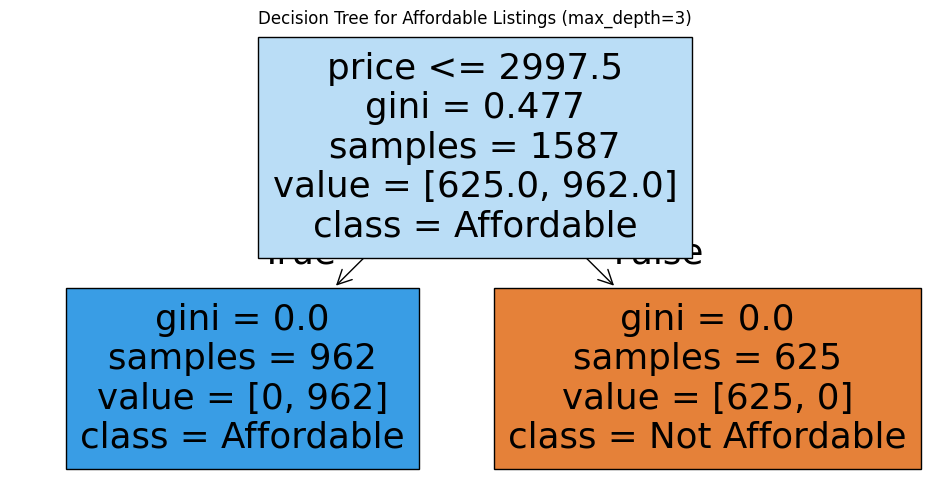

The tree splits on price first.

The structure for the second tree is more complex, but we can't see it due to the max_depth constraint. Clf_limited has more variables than clf, therefore, it must be more complex.

## 🔧 Part 7: Reflection (100 words or less per question)

1. Which feature was most useful in identifying affordable listings?  
2. Would you trust this model to recommend pricing to landlords?


Price was undoubtedly the most useful feature in determining affordable listings. Price was the feature that both decision trees split on first.

I would trust this model to recommend pricing to landlords. It seems like it is quite reliable, going off its accuracy score.



## Export Your Notebook to Submit in Canvas
- Use the instructions from Lab 1

In [18]:
!jupyter nbconvert --to html "lab_10_classification.ipynb"

[NbConvertApp] Converting notebook lab_10_classification.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 639945 bytes to lab_10_classification.html
